In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import tiktoken
import math 
import pandas as pd 
import os
import requests
import math
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu126
True


In [2]:
# get data
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/resolve/main/sales_textbook.txt?download=true'
    with open('data/sales_textbook.txt', 'wb') as f:
        f.write(requests.get(url).content)

with open('data/sales_textbook.txt', 'r') as f:
    text = f.read()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else cpu) 
 # 分词和嵌入表示
Encoding = tiktoken.get_encoding("cl100k_base") # 分词器
tokenized_text = Encoding.encode(text) # 获得分词后的数字编码表示
max_token_value = max(tokenized_text) # 最大的token值
tokenized_text = torch.tensor(tokenized_text,dtype = torch.long,device = device) # 分词后的词表转换成tensor格式
max_token_value

100069

In [73]:
# Hyerparameters
batch_size = 64
context_length = 32
d_model = 128
num_heads = 8
dropout_rate = 0.1

In [5]:
# split train and validation data
split_idx = int(len(tokenized_text)*0.8)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [9]:
# 训练数据
data = train_data
idxs = torch.randint(0,len(data) - context_length - 1,(batch_size,))
x_batch = torch.stack([data[idx:idx+context_length] for idx in idxs])
y_batch = torch.stack([data[idx+1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape)
print(y_batch.shape)

torch.Size([64, 32])
torch.Size([64, 32])


In [11]:
# 可视化查看一下批 次数据
# pd.DataFrame(x_batch[0].cpu().numpy())
# Encoding.decode(x_batch[0].cpu().numpy())

In [10]:
# token embedding
input_embedding_table = nn.Embedding(max_token_value+1,d_model).to(device)
x_batch_embedding = input_embedding_table(x_batch)
y_batch_embedding = input_embedding_table(y_batch)
print(x_batch_embedding.shape)
print(y_batch_embedding.shape)

torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


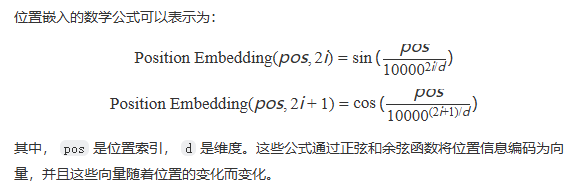

In [12]:
# position embedding
position_embedding_table = torch.zeros(context_length,d_model).to(device)
position = torch.arange(0,context_length,dtype = torch.float).unsqueeze(1)

# 准备训练数据 和 测试数据
div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000)/d_model))
position_embedding_table[:,0::2] = torch.sin(position * div_term)
position_embedding_table[:,1::2] = torch.cos(position * div_term)
position_embedding_table = position_embedding_table.unsqueeze(0).expand(batch_size,-1,-1)
print(position_embedding_table.shape)

torch.Size([64, 32, 128])


In [19]:
# encoding 
# 词嵌入 + 位置嵌入
x = x_batch_embedding + position_embedding_table
y = y_batch_embedding + position_embedding_table

# 到这里我们就准备好了输入数据了

device(type='cuda', index=0)

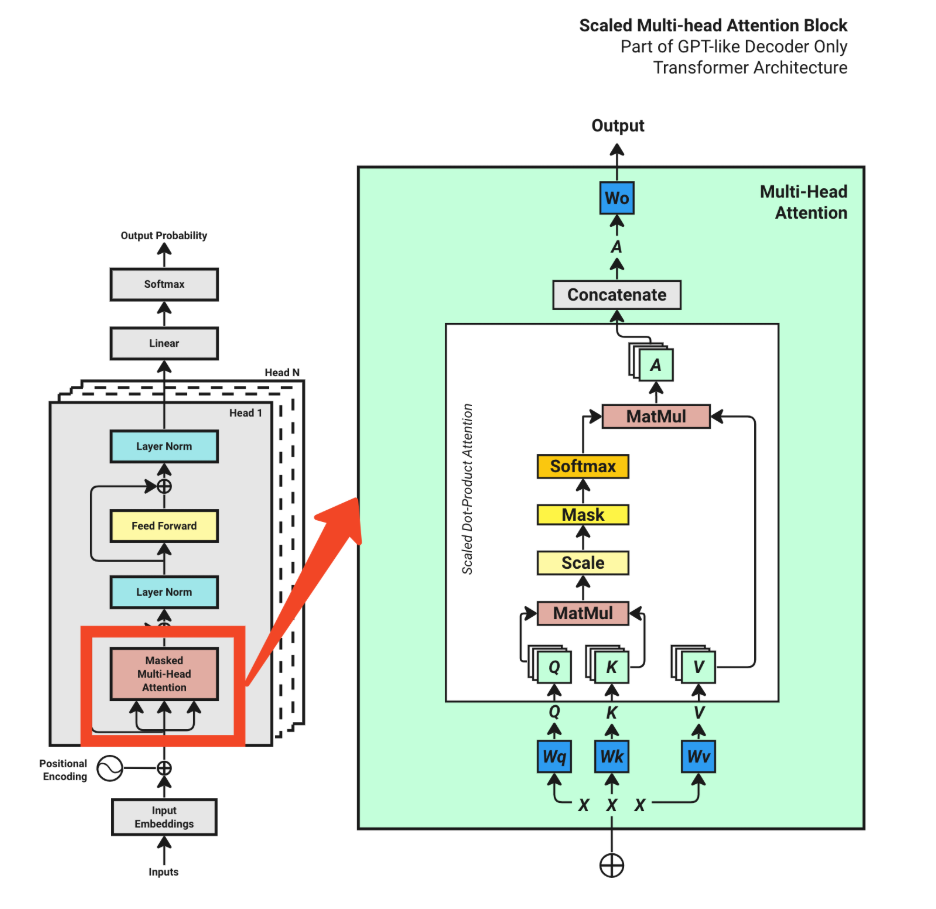

In [66]:
# get Q , K , V
Wq = nn.Linear(d_model,d_model,device=device)
Wk = nn.Linear(d_model,d_model,device=device)
Wv = nn.Linear(d_model,d_model,device=device)

Q = Wq(x)
K = Wk(x)
V = Wv(x)

# Q.shape,K.shape,V.shape

Q = Q.view(batch_size,context_length,num_heads,d_model//num_heads).permute(0,2,1,3)
K = K.view(batch_size,context_length,num_heads,d_model//num_heads).permute(0,2,1,3)
V = V.view(batch_size,context_length,num_heads,d_model//num_heads).permute(0,2,1,3)
print(Q.shape)
print(K.shape)
print(V.shape) # (batch_size , num_heads, context_length, d_model//num_heads)

torch.Size([64, 8, 32, 16])
torch.Size([64, 8, 32, 16])
torch.Size([64, 8, 32, 16])


In [56]:
attention_score = Q @ K.transpose(-1,-2)
attention_score = attention_score / math.sqrt(d_model // num_heads)
print(attention_score.shape)

torch.Size([64, 8, 32, 32])


In [64]:
# 设置掩码mask
# mask = torch.triu(torch.ones(attention_score.shape[-2:]),diagonal=1).bool() # 上三角矩阵实现
mask = torch.tril(torch.ones(attention_score.shape[-2:])).bool() # 下三角矩阵实现
mask = mask.to(device)
print(mask)
output = attention_score.masked_fill(mask==0,float('-inf')) 
# output = attention_score.masked_fill(mask==1,float('-inf')) # 等于1的地方都填充-inf值
# print(output)

tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0')


In [ ]:
# apply softmax
attention_score = F.softmax(output,dim=-1)
V = attention_score @ V
# print(V.shape) view()要求张量连续的，reshape不要求张量连续,更通用
# V = V.permute(0,2,1,3).contiguous().view(batch_size,context_length,d_model
V = V.permute(0,2,1,3).reshape(batch_size, context_length, d_model)
V.shape

torch.Size([64, 32, 128])

In [78]:
Wo = nn.Linear(d_model, d_model,device=device)
output = Wo(V)
output.shape

torch.Size([64, 32, 128])

In [79]:
# residual 残差连接
output = output + x
layer_norm = nn.LayerNorm(d_model,device=device)
output = layer_norm(output)

In [90]:
# apply feed forward network
output = nn.Linear(d_model, d_model * 4,device=device)(output)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4,d_model,device=device)(output)
output = nn.Dropout(dropout_rate)(output)
output = layer_norm(output)
output.shape

torch.Size([64, 32, 128])

In [96]:
# 生成最后的概率logits预测
logits = nn.Linear(d_model, max_token_value+1,device=device)(output)
probabilities = torch.softmax(logits,dim=-1)
print(probabilities.shape)
end = torch.argmax(probabilities,dim=-1)
print(end.shape)
# print(end[0].detach().cpu().numpy())
print(Encoding.decode(end[3].detach().cpu().numpy()))

torch.Size([64, 32, 100070])
torch.Size([64, 32])
 findOneHipHip AmbHipHip findOneHip findOneamañoamañoHipHip findOneHipHipHipHip segregated AmbHipHipHip leaseHip except Amb segregatedHip segregatedHip Amb


1 2 8
